In [1]:
import pandas as pd
import scanpy as sc
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## 1) Single cell analysis

In [2]:
import anndata

In [3]:
df = pd.read_table("data/csv/sc_10x_5cl.count.csv.gz", compression="gzip", sep=",")

In [4]:
df.head()

,Lib90_00000,Lib90_00001,Lib90_00002,Lib90_00003,Lib90_00004,Lib90_00005,Lib90_00006,Lib90_00007,Lib90_00008,Lib90_00009,...,Lib90_04012,Lib90_04014,Lib90_04017,Lib90_04019,Lib90_04024,Lib90_04026,Lib90_04028,Lib90_04029,Lib90_04048,Lib90_04057
COL27A1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SLC35B1,3,5,5,5,5,4,6,6,11,2,...,0,1,0,0,0,1,2,0,0,0
POLR3D,2,2,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SMC4,30,52,60,24,33,12,11,7,32,8,...,0,0,0,0,5,2,1,1,0,1
MAST2,4,2,0,1,0,5,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0



#### 1a) preparazione: filtro via tutti le cellule con molti geni mitocondriali (cellule morenti) e i geni del ciclo cellulare (variabilità all'interno della stessa linea)

In [5]:
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]

In [6]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

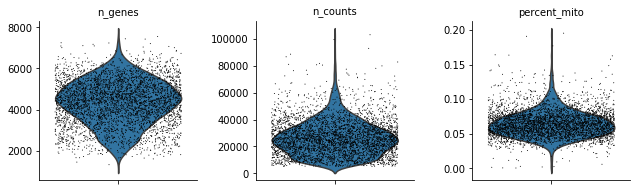

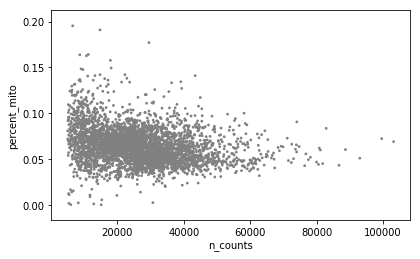

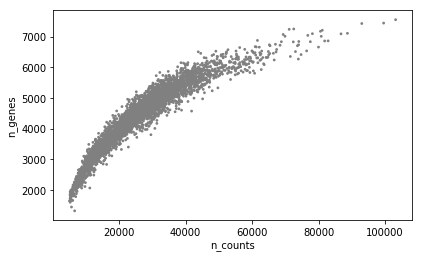

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]


In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [9]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


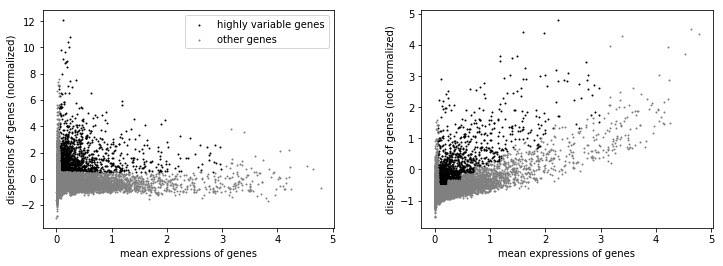

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [11]:
adata = adata[:, adata.var['highly_variable']]

In [12]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


#### 1b) PCA egrafico UMAP

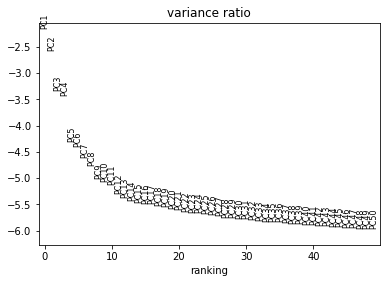

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [14]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [15]:
sc.tl.umap(adata) 

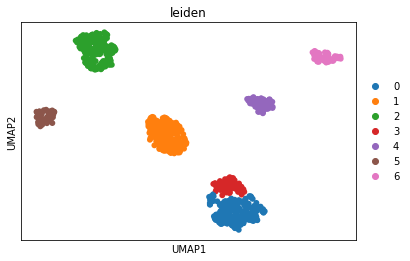

In [16]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color="leiden")

#### 1c) ora do i nomi ai cluster

In [17]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [18]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo

In [19]:
df_significativo.head()

,0,1,2,3,4,5,6
0,CD74,SEC61G,GAGE12D,XAGE1B,MT1E,AKR1B10,RPS28P7
1,LCN2,RPL7P9,GAGE12E,MMP7,LGALS1,KRT81,RPS15
2,SAA1,CDKN2A,GAGE12G,TMSB4X,DHRS2,AKR1C2,XAGE1B
3,CXCL1,RPL7,GAGE2E,RAC1,PEG10,ALDH1A1,AC007969.1
4,HLA-B,CHCHD2,GAGE2A,TPT1,RPS5,AKR1C3,LGALS1


###### siccome ci vengono 7 gruppi ma dovrebbero esserci solo 5 linee cellulari, controllo tramite enrichr che a quale gruppo appartenga la linea

In [20]:
for x in df_significativo.loc[:,'5']:
    print(x) #sono le a549

AKR1B10
KRT81
AKR1C2
ALDH1A1
AKR1C3
RPS16
GPX2
FTL
AKR1C1
RPS19
KRT18
KRT8
KRT18P17
G6PD
AGR2
PCBD1
PON2
S100A4
TKT
COX6B1


In [30]:
cell_annotation= pd.read_table('data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [22]:
cell_annotation.head()

,unaligned,aligned_unmapped,mapped_to_exon,mapped_to_intron,ambiguous_mapping,mapped_to_ERCC,mapped_to_MT,number_of_genes,total_count_per_cell,non_mt_percent,...,pct_counts_in_top_500_features,total_features,log10_total_features,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,cell_line,cell_line_demuxlet,demuxlet_cls
Lib90_00000,22485,2861,129248,10666,5503,0,9095,8344,104055,0.801874,...,67.118351,8344,3.921426,27.307674,39.538705,52.677911,67.118351,HCC827,HCC827,SNG
Lib90_00001,20325,2383,124178,11106,5308,0,9170,8216,100421,0.802860,...,68.047520,8216,3.914713,27.729260,40.342160,53.850290,68.047520,HCC827,HCC827,DBL
Lib90_00002,19279,2732,116260,9561,5064,0,6044,8121,93744,0.799806,...,61.432198,8121,3.909663,21.509643,32.380739,45.084485,61.432198,H838,H838,SNG
Lib90_00003,18580,2575,109675,11012,4764,0,6806,7809,89426,0.814897,...,71.056516,7809,3.892651,29.270011,43.419140,57.277526,71.056516,HCC827,HCC827,SNG
Lib90_00004,17759,2067,108807,9501,4809,0,4794,7807,87517,0.813591,...,67.645143,7807,3.892540,26.262326,39.047271,52.941714,67.645143,HCC827,HCC827,SNG


In [23]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line'],
      dtype='object')

In [24]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


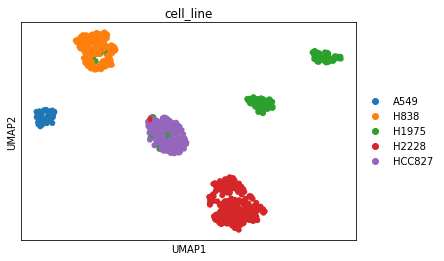

In [25]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line")

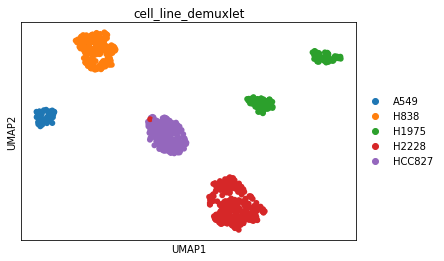

In [26]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line_demuxlet")

In [148]:
adata.write('adata_10x/adata_sc_10x.h5ad')

## 2) Grafi: Graph tool (per esercizio, lo uso meglio dopo)

In [99]:
import graph_tool.all as gt

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [100]:
g = gt.Graph(directed=False)

In [101]:
adata.uns['neighbors']

{'params': {'n_neighbors': 10, 'method': 'umap', 'metric': 'euclidean'},
 'distances': <860x860 sparse matrix of type '<class 'numpy.float64'>'
 	with 7740 stored elements in Compressed Sparse Row format>,
 'connectivities': <860x860 sparse matrix of type '<class 'numpy.float64'>'
 	with 12206 stored elements in Compressed Sparse Row format>}

In [102]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [103]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [104]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [105]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

##### non-nested SBM

In [106]:
state = gt.minimize_blockmodel_dl(g)

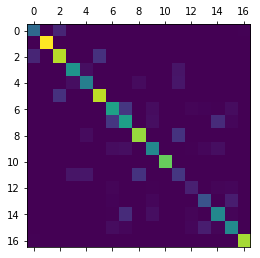

In [107]:
e= state.get_matrix()

matshow(e.todense())
#savefig("...")

##### Nested SBM

In [108]:
n_state = gt.minimize_nested_blockmodel_dl(g)

In [38]:
n_state.print_summary()

l: 0, N: 860, B: 50
l: 1, N: 50, B: 13
l: 2, N: 13, B: 4
l: 3, N: 4, B: 2
l: 4, N: 2, B: 1


In [39]:
levels = n_state.get_levels()
for s in levels:
    print(s)

<BlockState object with 50 blocks (50 nonempty), degree-corrected, for graph <Graph object, undirected, with 860 vertices and 5967 edges at 0x7f83460a0e90>, at 0x7f834793e150>
<BlockState object with 13 blocks (13 nonempty), for graph <Graph object, undirected, with 50 vertices and 248 edges at 0x7f8324e37c10>, at 0x7f8324e4c650>
<BlockState object with 4 blocks (4 nonempty), for graph <Graph object, undirected, with 13 vertices and 34 edges at 0x7f8324ea4490>, at 0x7f8324ea9990>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, undirected, with 4 vertices and 7 edges at 0x7f8324ea4250>, at 0x7f8324e34210>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 3 edges at 0x7f8324df4110>, at 0x7f8324eb1250>


##### Model selection

In [40]:
state_ndc = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)

print("Non-degree-corrected DL:\t", state_ndc.entropy())
print("Degree-corrected DL:\t", state_dc.entropy())

Non-degree-corrected DL:	 19522.996868517705
Degree-corrected DL:	 19946.370793301725


In [41]:
print(u"ln \u039b: ", state_dc.entropy() - state_ndc.entropy()) # sembra essere migliore la ndc

ln Λ:  423.37392478402035


In [109]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [117]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(2).get_blocks()))

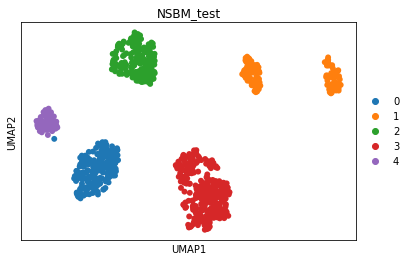

In [120]:
sc.pl.umap(adata, color="NSBM_test")

In [119]:
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,4,1,188
1,0,0,127,0,0
2,0,176,7,0,0
3,0,0,0,295,0
4,61,0,0,0,0


## 3) Paga
#### 3a) innanzitutto provo il Paga senza nessuna informazione

In [32]:
sc.tl.diffmap(adata)

sc.pp.neighbors(adata, n_neighbors=10)#, use_rep='X_diffmap')

In [33]:
sc.tl.leiden(adata, resolution=0.2)

In [34]:
sc.tl.paga(adata, groups='leiden')

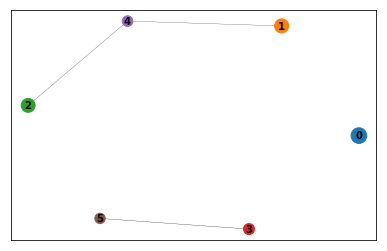

In [35]:
sc.pl.paga(adata, color=['leiden'])

In [36]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [37]:
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

#### 3b) istruisco il Paga con le cell lines

In [38]:
adata.obs['cell_line'].cat.categories

Index(['A549', 'H838', 'H1975', 'H2228', 'HCC827'], dtype='object')

In [39]:
sc.tl.paga(adata, groups='cell_line')

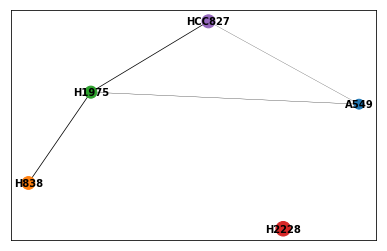

In [40]:
sc.pl.paga(adata, random_state=3124)

In [41]:
sc.tl.paga(adata, groups='cell_line_demuxlet')

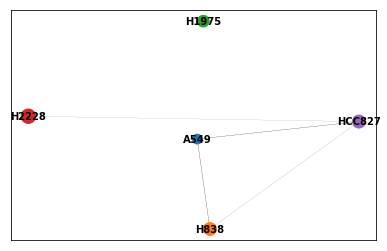

In [42]:
sc.pl.paga(adata, random_state=8)

#### 3c) provo a fare la computazione inizializzando con il Paga

In [43]:
sc.tl.draw_graph(adata, init_pos='paga')

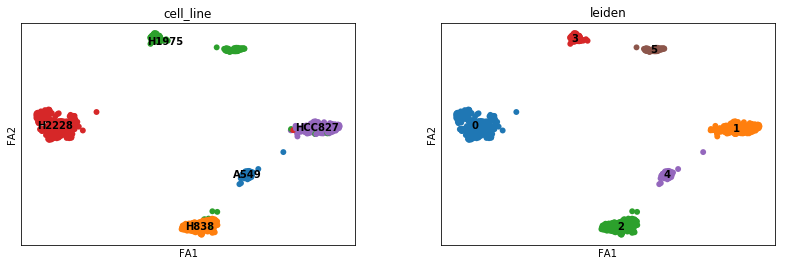

In [44]:
sc.pl.draw_graph(adata, color=['cell_line', 'leiden'], legend_loc='on data')

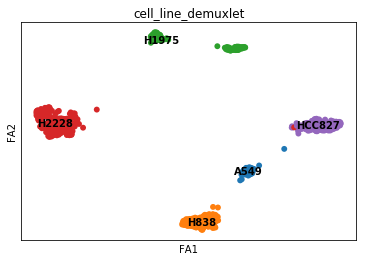

In [45]:
sc.pl.draw_graph(adata, color=['cell_line_demuxlet'], legend_loc='on data')

In [46]:
adata.write('paga_10x.h5ad')

## 4) Valutazione leiden/luvain vs. SBM

### 4a) leiden vs SBM: la valutazione di leiden

In [47]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [48]:
sc.tl.umap(adata) 

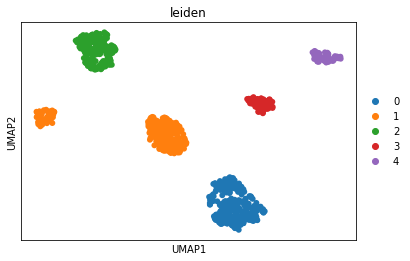

In [49]:
sc.tl.leiden(adata, resolution=0.025)
sc.pl.umap(adata, color="leiden") #nonostante cambi ogni risoluzione, leiden fa 5 gruppi ma sbaglia, ne classifica male due

##### itero le risoluzioni di leiden per trovare il range migliore in cui leiden riconosca 5 gruppi

In [50]:
resolutions = np.arange(0, 1, 0.005)
leiden_clusters = pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [51]:
for r in resolutions:
    sc.tl.leiden(adata, resolution=r)
    leiden_clusters.loc[:, r] = adata.obs.leiden

In [74]:
leiden_clusters.to_csv('adata_10x/10x_leiden_clusters.csv')

#### 4a.I) ho selezionato il modello di nested SBM non-degree corrected: lo valuto

In [56]:
import graph_tool.all as gt
g = gt.Graph(directed=False)

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [57]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [58]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [59]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [60]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [67]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [68]:
n_state

<NestedBlockState object, with base <BlockState object with 64 blocks (64 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f960bce4d90>, at 0x7f960ba71d10>, and 5 levels of sizes [(860, 64), (64, 14), (14, 5), (5, 2), (2, 1)] at 0x7f960bf94510>

In [69]:
n_state.print_summary()

l: 0, N: 860, B: 64
l: 1, N: 64, B: 14
l: 2, N: 14, B: 5
l: 3, N: 5, B: 2
l: 4, N: 2, B: 1


In [70]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(2).get_blocks()))

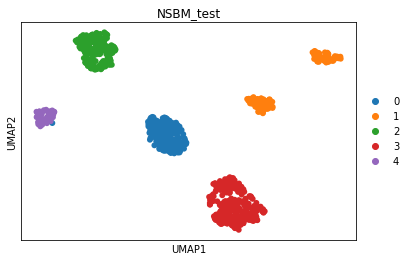

In [71]:
sc.pl.umap(adata, color="NSBM_test")

In [76]:
NSBM_clusters=pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)
print(NSBM_clusters)

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             1     0      4      1     188
1             0     0    127      0       0
2             0   176      7      0       0
3             0     0      0    295       0
4            61     0      0      0       0


In [78]:
NSBM_clusters.to_csv('adata_10x/10x_nsbm_clusters.csv')

#### 4a.II) mutual information: confronto leiden e SBM

In [88]:
import sklearn.metrics

##### mutua informazione tra sbm e adata

In [101]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, adata.obs.cell_line)

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9521213189358717

##### mutua informazione tra sbm e leiden (risoluzione 0.025)

In [102]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,0.025])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8907273147959685

##### mutua informazione leiden (r=0.025) e adata

In [103]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,0.025])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8471854700733557

##### qui faccio il grafico per paragonarne i profili

In [104]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

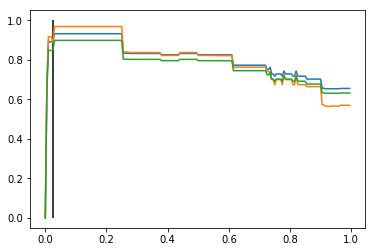

In [105]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl)
vlines(0.025, 0, 1)

##### vedo il profilo di mi di sbm

In [106]:
NSBM = np.array([list(n_state.project_level(x).get_blocks()) for x in range(5)])
NSBM

array([[ 0, 25, 25, ..., 11, 61,  9],
       [ 0,  1,  1, ...,  6, 13,  3],
       [ 0,  1,  1, ...,  3,  4,  2],
       [ 0,  1,  1, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [107]:
MI_nsbm = [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, NSBM[x]) for x in range(5)]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

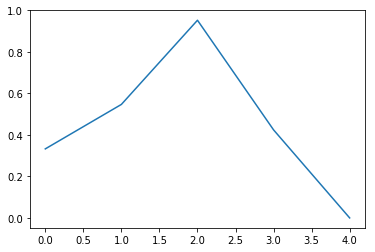

In [108]:
plot(range(5), MI_nsbm)

##### vedo che il gruppo 2 è quello che da una maggiore mutua informazione
#### 4a.III) dataframe leiden vs. sbm: paragone MI tra ogni risoluzione di leiden e i 5 livelli di NSBM

#### heatmap 5(sbm) x 200 (risoluzioni leiden da 0 a 1)

In [109]:
SBM_gruppi=pd.Categorical(adata.obs.NSBM_test).unique()
SBM_gruppi

[0, 1, 2, 3, 4]
Categories (5, int64): [0, 1, 2, 3, 4]

In [110]:
leiden_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [111]:
leiden_vs_SBM.head()

,0,1,2,3,4
0.000,NaN,NaN,NaN,NaN,NaN
0.005,NaN,NaN,NaN,NaN,NaN
0.010,NaN,NaN,NaN,NaN,NaN
0.015,NaN,NaN,NaN,NaN,NaN
0.020,NaN,NaN,NaN,NaN,NaN


#### MI tra le resolution di leiden e i livelli 0,1,2,3,4 di NSBM

In [123]:
MI_leiden_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM3= [sklearn.metrics.adjusted_mutual_info_score( NSBM[3], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM4= [sklearn.metrics.adjusted_mutual_info_score( NSBM[4], leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

#### ora devo mettere i valori di queste liste nel dataframe

In [124]:
leiden_vs_SBM.loc[:,0]=MI_leiden_NSBM0
leiden_vs_SBM.loc[:,1]=MI_leiden_NSBM1
leiden_vs_SBM.loc[:,2]=MI_leiden_NSBM2
leiden_vs_SBM.loc[:,3]=MI_leiden_NSBM3
leiden_vs_SBM.loc[:,4]=MI_leiden_NSBM4

In [125]:
MI_leiden_NSBM4[0:4]

[1.0, 7.81242578344332e-16, 1.44593652306206e-16, 1.44593652306206e-16]

In [126]:
leiden_vs_SBM.head()

,0,1,2,3,4
0.000,-4.50173e-17,-1.59039e-16,5.16431e-16,0,1
0.005,0.229802,0.376875,0.659977,0.697422,7.81243e-16
0.010,0.309744,0.508826,0.890904,0.516812,1.44594e-16
0.015,0.309744,0.508826,0.890904,0.516812,1.44594e-16
0.020,0.309744,0.508826,0.890904,0.516812,1.44594e-16


In [127]:
leiden_vs_SBM.to_csv('adata_10x/10x_mi_leiden_nsbm.csv')

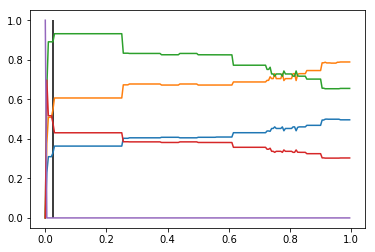

In [128]:
plot(leiden_vs_SBM)
vlines(0.025, 0, 1)

### 4b) louvain vs SBM

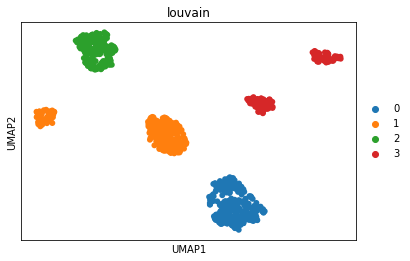

In [80]:
sc.tl.louvain(adata, resolution=0.045)
sc.pl.umap(adata, color="louvain") 

In [81]:
resolutions= np.arange(0, 1, 0.005)
louvain_clusters= pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [82]:
for r in resolutions:
    sc.tl.louvain(adata, resolution=r)
    louvain_clusters.loc[:, r] = adata.obs.louvain

In [83]:
louvain_clusters.to_csv('adata_10x/10x_louvain_clusters.csv')

#### mutua informazione tra smb e louvain (r=0.045)

In [89]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,0.045])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8909041895314882

#### mutua informazione louvain vs cell (r=0.045)

In [90]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,0.045])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8474317988374025

In [91]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

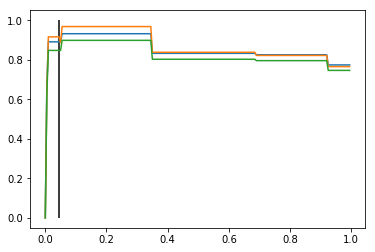

In [92]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl) #verde
vlines(0.045, 0, 1)

In [98]:
louvain_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [112]:
MI_louvain_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM3= [sklearn.metrics.adjusted_mutual_info_score( NSBM[3], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM4= [sklearn.metrics.adjusted_mutual_info_score( NSBM[4], louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [113]:
louvain_vs_SBM.loc[:,0]=MI_louvain_NSBM0
louvain_vs_SBM.loc[:,1]=MI_louvain_NSBM1
louvain_vs_SBM.loc[:,2]=MI_louvain_NSBM2
louvain_vs_SBM.loc[:,3]=MI_louvain_NSBM3
louvain_vs_SBM.loc[:,4]=MI_louvain_NSBM4

In [114]:
MI_louvain_NSBM4[0:5]

[1.0,
 7.81242578344332e-16,
 1.44593652306206e-16,
 1.44593652306206e-16,
 1.44593652306206e-16]

In [122]:
louvain_vs_SBM.head()
imshow(louvain_vs_SBM, cmap=cm.Reds,vmin, vmax)

SyntaxError: positional argument follows keyword argument (<ipython-input-122-37d3d5b65982>, line 2)

In [118]:
louvain_vs_SBM.to_csv('adata_10x/10x_mi_louvain_nsbm.csv')

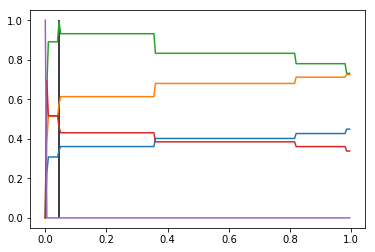

In [112]:
plot(louvain_vs_SBM)
vlines(0.045, 0, 1)

## 5) Sampling for the posterior distribution
### 5a) mcmc.equilibrate() per capire quanti blocchi sono più probabili per ogni livello

In [133]:
bs = n_state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

In [134]:
state = n_state.copy(bs=bs, sampling=True)

In [135]:
dS, nattempts, nmoves = state.mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 34.70479505939224
Number of accepted vertex moves: 303021


In [136]:
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

(19545.910515371306, 60160664, 19380335)

In [137]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1

In [138]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(19528.936959461626, 96626273, 31013832)

In [140]:
import pickle #per salvare la lista h come una variabile

In [145]:
pickle.dump(h, open('adata_10x/10x_block_probability', 'wb'))

### 5b) Model class selection: selezionare il modello migliore in base all'entropia del grafo e alla sua descriptiion length

In [89]:
nL = 10

for deg_corr in [True, False]:
    state = gt.minimize_nested_blockmodel_dl(g, deg_corr=deg_corr) 

In [91]:
bs = state.get_bs()                     
bs += [np.zeros(1)] * (nL - len(bs))

In [92]:
state = state.copy(bs=bs, sampling=True)

In [93]:
dls = []                               # description length history
vm = [None] * len(state.get_levels())  # vertex marginals
em = None                              # edge marginals

In [94]:
def collect_marginals(s):
    global vm, em
    levels = s.get_levels()
    vm = [sl.collect_vertex_marginals(vm[l]) for l, sl in enumerate(levels)]
    em = levels[0].collect_edge_marginals(em)
    dls.append(s.entropy())

In [95]:
gt.mcmc_equilibrate(state, force_niter=20000, mcmc_args=dict(niter=10), callback=collect_marginals)

(19483.337072723396, 191107744, 66808602)

In [96]:
S_mf = [gt.mf_entropy(sl.g, vm[l]) for l, sl in enumerate(state.get_levels())]
S_bethe = gt.bethe_entropy(g, em)[0]
L = -mean(dls)

print("Model evidence for deg_corr = %s:" % deg_corr, L + sum(S_mf), "(mean field),", L + S_bethe + sum(S_mf[1:]), "(Bethe)")


Model evidence for deg_corr = False: -18968.157685222523 (mean field), -19118.780385077655 (Bethe)


In [147]:
type(adata)

anndata.core.anndata.AnnData